### Esercitazione 18 - MFI (Money Flow Index)
#### Argomenti

* indicatore MFI
* MFI vs RSI
* applicazione delle due strategie usate con RSI (esercitazione 10) su MFI

Il Money Flow Index (MFI) è un indicatore di Momentum che misura il flusso di denaro
in entrata e in uscita da uno strumento finanziario in un determinato periodo di tempo.
È correlato al Relative Strength Index (RSI) ma incorpora il volume, mentre l'RSI
considera solo il prezzo.    
Il MFI viene calcolato accumulando valori di Money Flow
positivi e negativi, quindi creando un Money Ratio. Il Money Ratio viene quindi
normalizzato nella forma dell'oscillatore MFI.

Money Flow Index = 100 − 100 / (1 + Money Flow Ratio)
dove
Money Flow Ratio = Positive Money Flow in n periodi / Negative Money Flow in n periodi

Raw Money Flow = Typical Price * Volume

Typical Price = (High + Low + Close) / 3

Quando il prezzo avanza da un periodo al successivo, il Raw Money Flow è positivo e
viene aggiunto al Positive Money Flow. Quando Raw Money Flow è negativo perché il
prezzo è sceso in quel periodo, viene aggiunto a Negative Money Flow.

L'MFI e la RSI sono strettamente correlati. La differenza principale è che MFI
incorpora il volume, mentre l'RSI no.
Siccome non ci sono prove matematiche relative alla bontà di un indicatore rispetto
ad un altro, possiamo solo dire che MFI e RSI utilizzano input diversi e, quindi,
generano segnali diversi.

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from collections import deque
import numpy as np

In [2]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_D1, 0, 500))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

In [3]:
# utilizziamo Ta-Lib per il calcolo del MFI
candles['mfi'] = talib.MFI(candles['high'], candles['low'], candles['close'], candles['tick_volume'], timeperiod=14)

candles.tail()

,open,high,low,close,tick_volume,spread,real_volume,mfi
time,,,,,,,,
2022-12-05,1.05363,1.05943,1.04798,1.04938,127495,5,0,65.465904
2022-12-06,1.04946,1.05325,1.04588,1.04654,117486,5,0,60.288989
2022-12-07,1.04655,1.05493,1.04427,1.05069,132758,5,0,68.129593
2022-12-08,1.05089,1.05643,1.04889,1.05556,111730,5,0,68.515743
2022-12-09,1.05544,1.05879,1.05461,1.05565,44056,5,0,66.925431


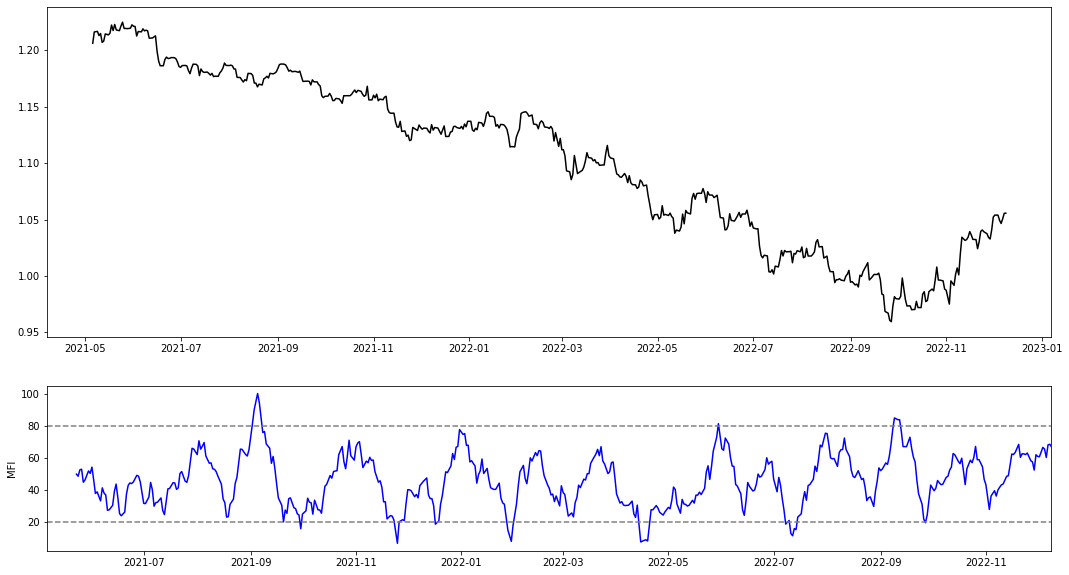

In [4]:
# visualizzazione del MFI su un grafico

fig, (ax_price, ax_mfi) = plt.subplots(2, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})

ax_price.plot(candles.index, candles['close'], color='black')
plt.autoscale(True, axis='x', tight=True)

ax_mfi.plot(candles.index, candles['mfi'], color='blue')
ax_mfi.hlines(20, xmin=candles.index[0], xmax=candles.index[-1], color='gray', linestyle='--')
ax_mfi.hlines(80, xmin=candles.index[0], xmax=candles.index[-1], color='gray', linestyle='--')
ax_mfi.set_ylabel('MFI')

plt.show()

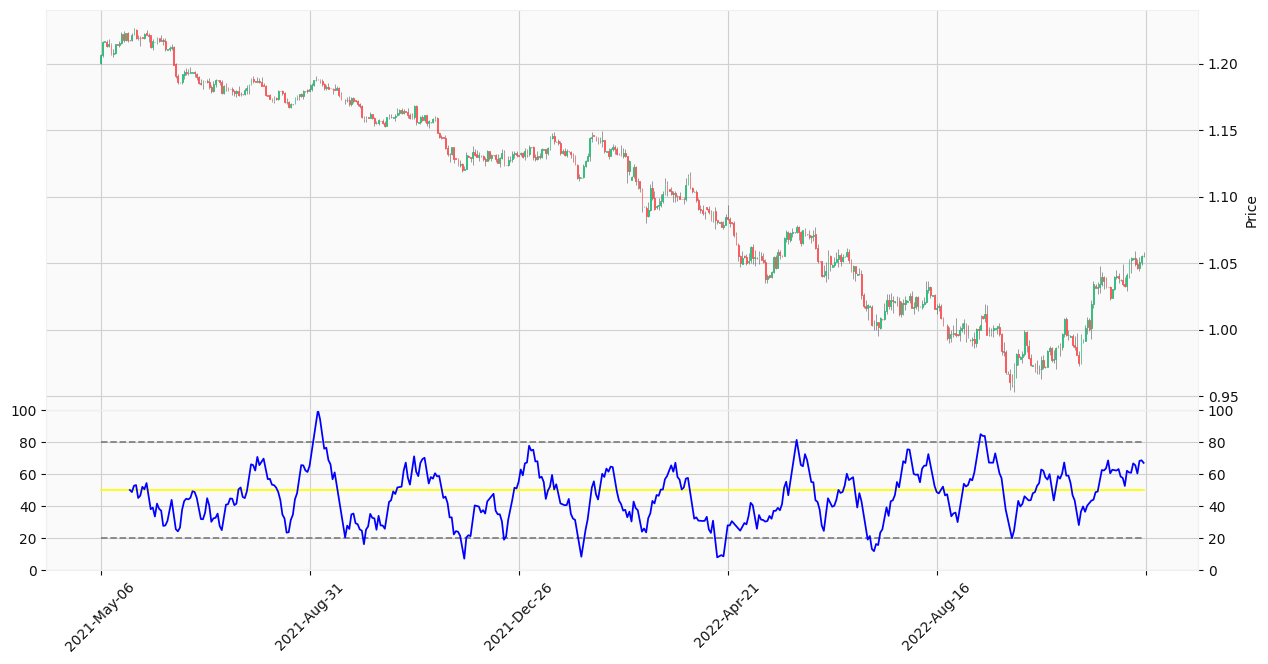

In [5]:
n_candele = len(candles)

mfi_plot = mpf.make_addplot(candles['mfi'], color='blue', panel=1, ylim=(0, 100))
mfi_upper_plot = mpf.make_addplot([80] * n_candele, color='gray', linestyle='--', panel=1, ylim=(0, 100))
mfi_middle_plot = mpf.make_addplot([50] * n_candele, color='yellow', panel=1, ylim=(0, 100))
mfi_lower_plot = mpf.make_addplot([20] * n_candele, color='gray', linestyle='--', panel=1, ylim=(0, 100))
mpf.plot(candles, addplot=[mfi_upper_plot, mfi_middle_plot, mfi_lower_plot, mfi_plot], type='candle', style='yahoo', figsize=(16, 8))

### implementazione di una procedura per l'identificazione delle divergenze rialziste e ribassiste tramite MFI

In [6]:
# metodi per il rilevamento dei picchi (minimi / massimi) consecutivi nei livelli di prezzo
# in modo da evidenziarne il trend, per poterlo poi confrontare con quello generato dal MFI
# alla ricerca di convergenze e divergenze per generare segnali

def massimi_crescenti_consecutivi(data, order=5, K=2):
    '''
    Trova massimi decrescenti consecutivi in [data]
    order: indica quanti dati consecutivi considerare in ogni finestra
    K: indica quanti picchi consecutivi si devono avere per confermare la condizione di massimi crescenti consecutivi
    '''
    high_idx = argrelextrema(data, np.greater, order=order)[0]
    highs = data[high_idx]
    # check per verificare che i livelli selezionati siano consecutivi
    picchi = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
        elif highs[i] < highs[i - 1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            picchi.append(ex_deque.copy())
    return picchi


# similmente possiamo implementare:

def massimi_decrescenti_consecutivi(data, order=5, K=2):
    high_idx = argrelextrema(data, np.greater, order=order)[0]
    highs = data[high_idx]
    picchi = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
        elif highs[i] > highs[i - 1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            picchi.append(ex_deque.copy())
    return picchi


def minimi_crescenti_consecutivi(data, order=5, K=2):
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    picchi = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
        elif lows[i] < lows[i - 1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            picchi.append(ex_deque.copy())
    return picchi


def minimi_decrescenti_consecutivi(data: np.array, order=5, K=2):
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
    picchi = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
        elif lows[i] > lows[i - 1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            picchi.append(ex_deque.copy())
    return picchi

In [7]:
prices = candles['close'].values
dates = candles.index

order = 5
hh = massimi_crescenti_consecutivi(prices, order)
lh = massimi_decrescenti_consecutivi(prices, order)
hl = minimi_crescenti_consecutivi(prices, order)
ll = minimi_decrescenti_consecutivi(prices, order)

# recupero l'id finale di ogni intervallo (id_inizio_intervallo, id_fine_intervallo)
hh_idx = np.array([i[1] for i in hh])
lh_idx = np.array([i[1] for i in lh])
ll_idx = np.array([i[1] for i in ll])
hl_idx = np.array([i[1] for i in hl])

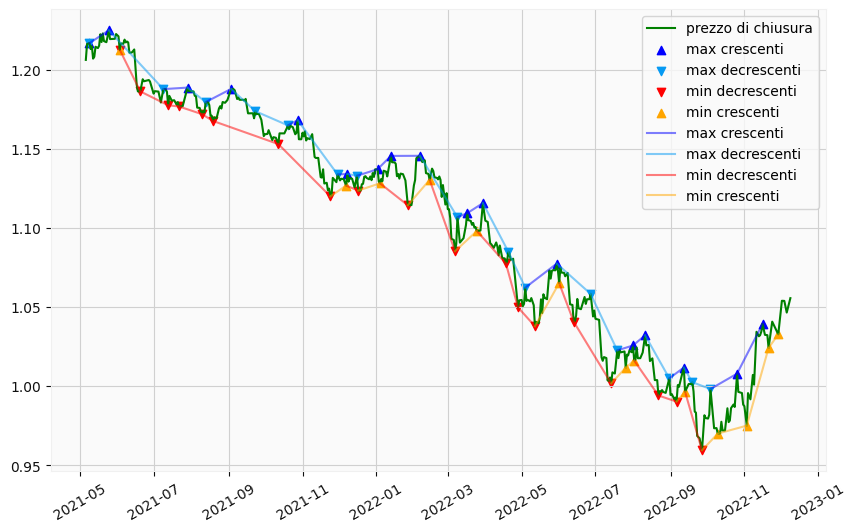

In [8]:
# visualizzazione dei picchi e dei relativi trend

plt.figure(figsize=(10, 6))
plt.xticks(rotation=30)

plt.plot(candles['close'], color='green', label='prezzo di chiusura')

plt.scatter(dates[hh_idx], prices[hh_idx], marker='^', c='blue', label='max crescenti')
plt.scatter(dates[lh_idx], prices[lh_idx], marker='v', c='#069AF3', label='max decrescenti')
plt.scatter(dates[ll_idx], prices[ll_idx], marker='v', c='red', label='min decrescenti')
plt.scatter(dates[hl_idx], prices[hl_idx], marker='^', c='orange', label='min crescenti')

for i in hh:
    if i == hh[0]:
        plt.plot(dates[i], prices[i], c='blue', alpha=0.5, label='max crescenti')
    else:
        plt.plot(dates[i], prices[i], c='blue', alpha=0.5)
for i in lh:
    if i == lh[0]:
        plt.plot(dates[i], prices[i], c='#069AF3', alpha=0.5, label='max decrescenti')
    else:
        plt.plot(dates[i], prices[i], c='#069AF3', alpha=0.5)
for i in ll:
    if i == ll[0]:
        plt.plot(dates[i], prices[i], c='red', alpha=0.5, label='min decrescenti')
    else:
        plt.plot(dates[i], prices[i], c='red', alpha=0.5)
for i in hl:
    if i == hl[0]:
        plt.plot(dates[i], prices[i], c='orange', alpha=0.5, label='min crescenti')
    else:
        plt.plot(dates[i], prices[i], c='orange', alpha=0.5)

plt.legend()
plt.show()

In [9]:
# metodi per il recupero degli indici dei picchi HH, HL, LH, LL

def get_hh_indexes(data: np.array, order=5, K=2):
    picchi = massimi_crescenti_consecutivi(data, order, K)
    idx = np.array([i[-1] + order for i in picchi])
    return idx[np.where(idx < len(data))]


def get_lh_indexes(data: np.array, order=5, K=2):
    picchi = minimi_crescenti_consecutivi(data, order, K)
    idx = np.array([i[-1] + order for i in picchi])
    return idx[np.where(idx < len(data))]


def get_ll_indexes(data: np.array, order=5, K=2):
    picchi = minimi_decrescenti_consecutivi(data, order, K)
    idx = np.array([i[-1] + order for i in picchi])
    return idx[np.where(idx < len(data))]


def get_hl_indexes(data: np.array, order=5, K=2):
    picchi = massimi_decrescenti_consecutivi(data, order, K)
    idx = np.array([i[-1] + order for i in picchi])
    return idx[np.where(idx < len(data))]


# metodo per rilevare i picchi (HH, HL, LH, LL) in una distribuzione di dati
def get_picchi(data, key, order=5, K=2):
    data = data.copy()
    vals = data[key].values
    hh_idx = get_hh_indexes(vals, order, K)
    lh_idx = get_lh_indexes(vals, order, K)
    ll_idx = get_ll_indexes(vals, order, K)
    hl_idx = get_hl_indexes(vals, order, K)
    data[f'{key}_highs'] = np.nan
    data.loc[data.iloc[hh_idx].index, f'{key}_highs'] = 1
    data.loc[data.iloc[lh_idx].index, f'{key}_highs'] = -1
    data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
    data[f'{key}_lows'] = np.nan
    data.loc[data.iloc[ll_idx].index, f'{key}_highs'] = 1
    data.loc[data.iloc[hl_idx].index, f'{key}_highs'] = 1
    data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
    return data


def strategia_divergenze_mfi(data, interval=14, order=5, K=2):
    '''
    Si entra in buy/sell sulle divergenze tra prezzo e MFI:
    - Buy se il prezzo ha minimi decrescenti, MFI ha minimi crescenti e l'MFI è < 50
    - Sell se il prezzo ha massimi crescenti, MFI ha massimi decrescenti e l'MFI è > 50

    Si esce da una posizione quando l'MFI fa un ritracciamento sul suo valore al momento
    dell'apertura oppure attraversa la linea centrale (valore 50)
    '''
    data = get_picchi(data, key='close', order=order, K=K)
    data['mfi'] = talib.MFI(data.high, data.low, data.close, data.tick_volume, timeperiod=interval)
    data = get_picchi(data, key='mfi', order=order, K=K)

    position = np.zeros(data.shape[0])
    for i, (t, row) in enumerate(data.iterrows()):
        if position[i - 1] == 0:
            # divergenza tra trend MFI e Prezzo + MFI nella fascia bassa-> buy
            if row['close_lows'] == -1 and row['mfi_lows'] == 1:
                if row['mfi'] < 50:
                    position[i] = 1
                    entry_mfi = row['mfi'].copy()

            # divergenza tra trend MFI e Prezzo + MFI nella fascia alta-> sell
            elif row['close_highs'] == 1 and row['mfi_highs'] == -1:
                if row['mfi'] > 50:
                    position[i] = -1
                    entry_mfi = row['mfi'].copy()

        # verifica se restare in buy
        elif position[i - 1] == 1:
            if row['mfi'] < 50 and row['mfi'] < entry_mfi:
                position[i] = 1

        # verifica se restare in sell
        elif position[i - 1] == -1:
            if row['mfi'] > 50 and row['mfi'] > entry_mfi:
                position[i] = -1

    data['position'] = position

    return data, get_returns(data)


def get_returns(df):
    '''
    metodo per la verifica dei guadagni / perdite
    riutilizzata anche nella strategia illustrata successivamente

    da notare che il calcolo del ritorno dell'investimento è ottenuto simulando di giocare su ogni candela in cui è
    generato un segnale +1 o -1, non considerando eventuali candele consecutive in un'unica giocata

    adoperando questa tecnica su un dataframe possiamo parallelizzare i calcoli velocizzandone l'esecuzione
    '''

    df['returns'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)

    df['strat_returns'] = df['position'] * df['returns']

    df['cum_returns'] = df['returns'].cumsum()
    df['strat_cum_returns'] = df['strat_returns'].cumsum()
    return df

In [10]:
# recupero dati storici e calcolo dei risultati della strategia basata sulle divergenze tra trend di prezzi e MFI

connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURCAD', mt5.TIMEFRAME_D1, 0, 500))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

data, res = strategia_divergenze_mfi(candles)

In [11]:
res.tail()

,open,high,low,close,tick_volume,spread,real_volume,close_highs,close_lows,mfi,mfi_highs,mfi_lows,position,returns,strat_returns,cum_returns,strat_cum_returns
time,,,,,,,,,,,,,,,,,
2022-12-05,1.41864,1.42725,1.41319,1.42560,218215,19,0,1.0,1.0,72.929816,1.0,1.0,0.0,0.004757,0.000000,-0.023538,-0.082085
2022-12-06,1.42534,1.43491,1.42453,1.42843,211138,19,0,1.0,1.0,75.407221,1.0,1.0,0.0,0.001985,0.000000,-0.021553,-0.082085
2022-12-07,1.42842,1.44023,1.42648,1.43417,212544,19,0,1.0,1.0,83.538481,1.0,1.0,0.0,0.004018,0.000000,-0.017535,-0.082085
2022-12-08,1.43377,1.43986,1.42766,1.43368,187004,19,0,1.0,1.0,90.125298,-1.0,-1.0,-1.0,-0.000342,0.000342,-0.017876,-0.081744
2022-12-09,1.43365,1.44149,1.43326,1.43893,65479,19,0,1.0,1.0,89.573137,-1.0,-1.0,0.0,0.003662,0.000000,-0.014214,-0.081744


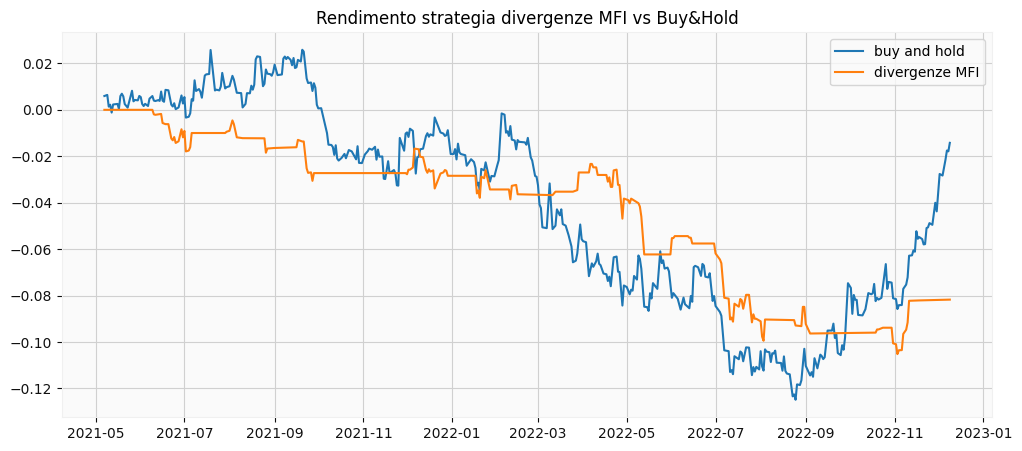

In [12]:
# visualizzazione del rendimento della strategia rispetto
# alla strategia "buy & hold"

plt.figure(figsize=(12, 5))
plt.plot(res['cum_returns'], label='buy and hold')
plt.plot(res['strat_cum_returns'], label='divergenze MFI')
plt.title('Rendimento strategia divergenze MFI vs Buy&Hold')
plt.legend()
plt.show()

In [13]:
# ulteriore strategia con sfruttamento medie mobili esponenziali
# come ulteriore segnale per operare

def _exp_moving_average(price, last_ema, n):
    return (price - last_ema) * (2 / (n + 1)) + last_ema


def exp_moving_average(data, key, n):
    # inizializzazione colonna media mobile non esponenziale [sma_n]
    data['sma_' + str(n)] = data[key].rolling(n).mean()

    # inizializzazione valori media mobile esponenziale
    ema = np.zeros(len(data))

    for i, _row in enumerate(data.iterrows()):
        row = _row[1]
        if i < n:
            ema[i] += row['sma_' + str(n)]
        else:
            ema[i] += _exp_moving_average(row['close'], ema[i - 1], n)
    data['ema_' + str(n)] = ema.copy()
    return data


def MFIDivergenceWithTrendStrategy(data, timeperiod=14, order=5, K=2, ema1=14, ema2=35):
    '''
    Generazione di segnali di buy e sell basandosi sulle divergenze tra i trend di prezzo e MFI
    * Si apre una posizione se non ce n'è un'altra aperta. in:
    * Si chiude la posizione precedentemente aperta quando le medie mobili esponenziali del prezzo
      stanno per incontrarsi
    '''
    data = get_picchi(data, key='close', order=order, K=K)
    data['mfi'] = talib.MFI(data.high, data.low, data.close, data.tick_volume, timeperiod=timeperiod)
    data = get_picchi(data, key='mfi', order=order, K=K)
    data = exp_moving_average(data, 'close', ema1)
    data = exp_moving_average(data, 'close', ema2)
    position = np.zeros(data.shape[0])

    for i, (_, row) in enumerate(data.iterrows()):
        # se non ci posizioni aperte
        if position[i - 1] == 0:
            # apri una posizione long se ci sono minimi decrescenti di prezzo, minimi crescenti di MFI e l'MFI è < 50
            if row['close_lows'] == -1 and row['mfi_lows'] == 1 and row[f'ema_{ema1}'] > row[f'ema_{ema2}']:
                if row['mfi'] < 50:
                    position[i] = 1
                    entry_ema = row[f'ema_{ema1}'] - row[f'ema_{ema2}']

            # apri una posizione short se ci sono massimi crescenti di prezzo, massimi decrescenti di MFI e l'MFI > 50
            elif row['close_highs'] == 1 and row['mfi_highs'] == -1 and row[f'ema_{ema1}'] < row[f'ema_{ema2}']:
                if row['mfi'] > 50:
                    position[i] = -1
                    entry_ema = row[f'ema_{ema2}'] - row[f'ema_{ema1}']

        # se siamo in buy verifichiamo se continuare
        # (di default [position] è impostato a 0, se il trend è ancora attivo impostiamo la [position] successiva ad 1
        # per mantenere aperta la posizione altrimenti resterà a 0 e e la posizione verrà chiusa)
        elif position[i - 1] == 1:
            if row[f'ema_{ema1}'] - row[f'ema_{ema2}'] > entry_ema * 0.1:
                position[i] = 1

        # se siamo in sell verifichiamo se continuare
        elif position[i - 1] == -1:
            if row[f'ema_{ema2}'] - row[f'ema_{ema1}'] > entry_ema * 0.1:
                position[i] = -1

    # aggiunta della colonna [position] al dataset
    data['position'] = position

    # calcolo rendimento strategia
    returns = get_returns(data)

    return returns

In [14]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_H1, 0, 3000))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

ema1 = 50
ema2 = 200
res = MFIDivergenceWithTrendStrategy(candles, timeperiod=14, ema1=ema1, ema2=ema2)

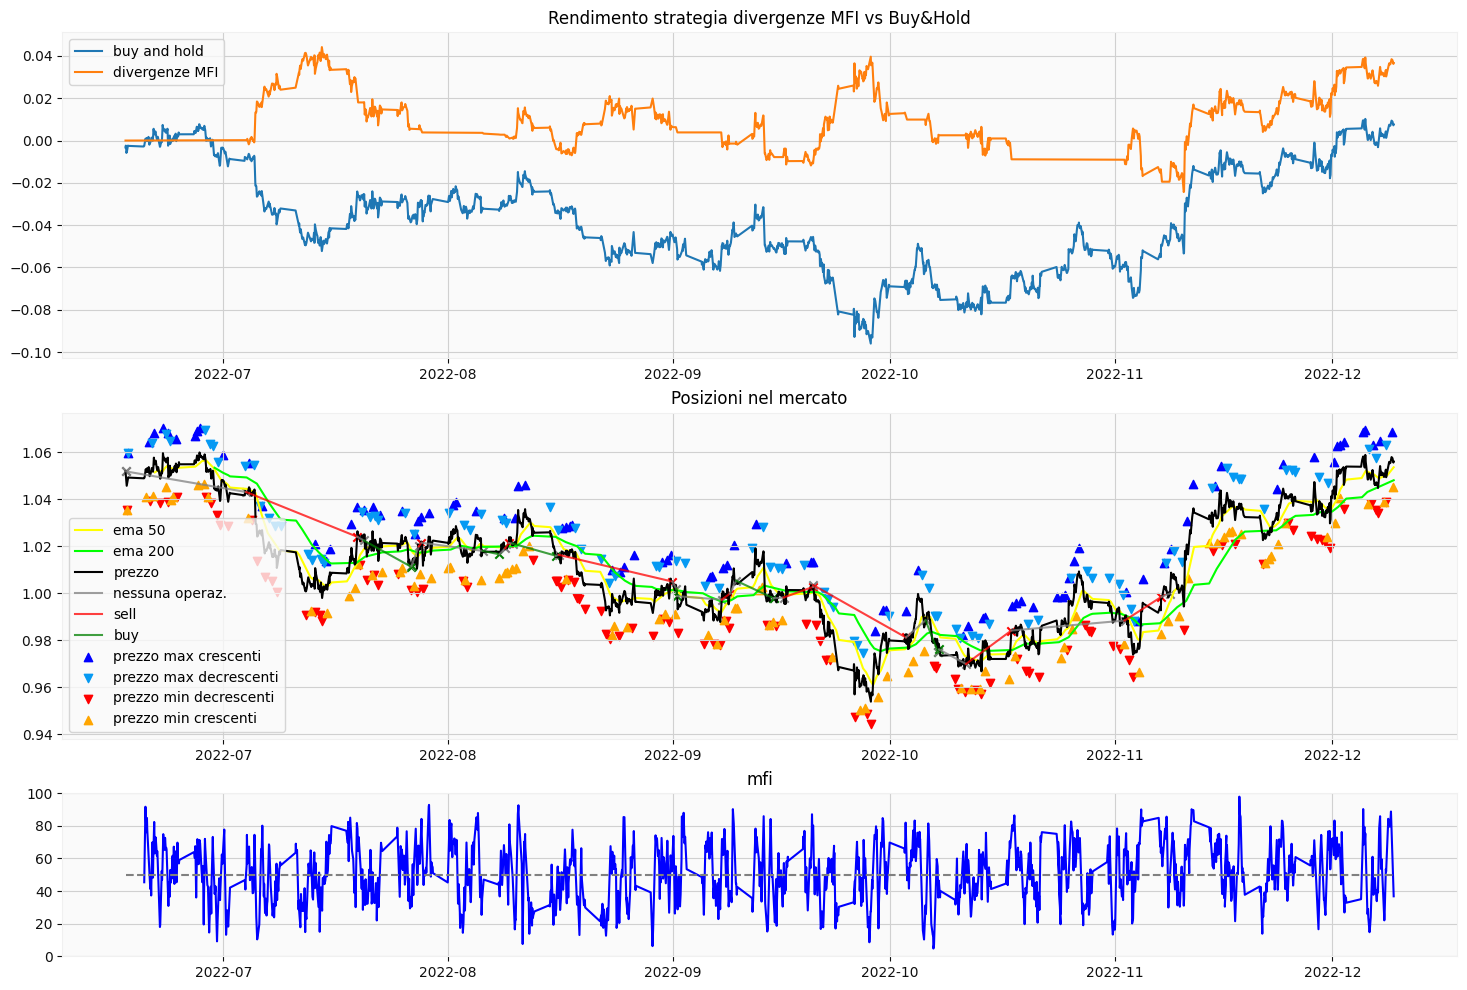

In [15]:
fig, (ax_returns, ax_positions, ax_mfi) = plt.subplots(3, figsize=(18, 12), gridspec_kw={'height_ratios': [2, 2, 1]})

# guadagni / perdite
ax_returns.plot(res['cum_returns'], label='buy and hold')
ax_returns.plot(res['strat_cum_returns'], label='divergenze MFI')
ax_returns.set_title('Rendimento strategia divergenze MFI vs Buy&Hold')
ax_returns.legend()

# posizioni sul mercato
ax_positions.plot(res['ema_' + str(ema1)], label='ema ' + str(ema1), color='yellow')
ax_positions.plot(res['ema_' + str(ema2)], label='ema ' + str(ema2), color='lime')
ax_positions.plot(res['close'], label='prezzo', color='black')

xs, ys, cs, ls = [], [], [], []
xs.append(res.iloc[0].name)
ys.append(res.iloc[0].close)
cs.append('gray')
ls.append('nessuna operaz.')

res['position_1'] = res['position'].shift(1)

xs.append(res.iloc[0].name)
ys.append(res.iloc[0].close)
cs.append('gray')
ls.append('nessuna operaz.')

for i in range(1, len(res)):
    c = res.iloc[i]
    if c.position != c.position_1:
        if c.position_1 == 1:
            cs.append('green')
            last_color = 'green'
            ls.append('buy')
            last_label = 'buy'
        elif c.position_1 == -1:
            cs.append('red')
            last_color = 'red'
            ls.append('sell')
            last_label = 'sell'
        else:
            cs.append('gray')
            last_color = 'gray'
            ls.append('nessuna operaz.')
            last_label = 'nessuna operaz.'
        xs.append(c.name)
        ys.append(c.close)

operazioni = []

for i in range(len(xs)):
    id_start = i - 1
    id_end = i + 1
    if ls[i:id_end] not in operazioni:
        operazioni.append(ls[i:id_end])
        ax_positions.plot(xs[id_start:id_end], ys[id_start:id_end], color=cs[i], alpha=0.75, label=ls[i])
    else:
        ax_positions.plot(xs[id_start:id_end], ys[id_start:id_end], color=cs[i], alpha=0.75)
    ax_positions.scatter(xs[i], ys[i], color=cs[i], marker='x')

ax_positions.set_title('Posizioni nel mercato')

order = 5
prices = res.close.values
dates = res.index

p_hh = massimi_crescenti_consecutivi(prices, order=5)
p_lh = massimi_decrescenti_consecutivi(prices, order=5)
p_hl = minimi_crescenti_consecutivi(prices, order=5)
p_ll = minimi_decrescenti_consecutivi(prices, order=5)

# recupero l'id finale di ogni intervallo (id_inizio_intervallo, id_fine_intervallo)
p_hh_idx = np.array([i[1] for i in p_hh])
p_lh_idx = np.array([i[1] for i in p_lh])
p_ll_idx = np.array([i[1] for i in p_ll])
p_hl_idx = np.array([i[1] for i in p_hl])

ax_positions.scatter(dates[p_hh_idx], prices[p_hh_idx] + prices[p_hh_idx] * 0.01, marker='^', c='blue', label='prezzo max crescenti')
ax_positions.scatter(dates[p_lh_idx], prices[p_lh_idx] + prices[p_lh_idx] * 0.01, marker='v', c='#069AF3', label='prezzo max decrescenti')
ax_positions.scatter(dates[p_ll_idx], prices[p_ll_idx] - prices[p_ll_idx] * 0.01, marker='v', c='red', label='prezzo min decrescenti')
ax_positions.scatter(dates[p_hl_idx], prices[p_hl_idx] - prices[p_hl_idx] * 0.01, marker='^', c='orange', label='prezzo min crescenti')

ax_positions.legend()

ax_mfi.plot(res['mfi'], color='blue')
ax_mfi.hlines(50, xmin=res.index[0], xmax=res.index[-1], linestyles='--', color='gray')
ax_mfi.set_ylim(0, 100)
ax_mfi.set_title('mfi')
plt.show()